<a href="https://colab.research.google.com/github/eweaverdyck/Eniac_discounts/blob/main/Master_Notebook_Cleaning_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings("ignore")

In [2]:
def gd_path(file_id):
  return f"https://drive.google.com/uc?export=download&id={file_id}"

files_url = {
  'products': 'https://drive.google.com/file/d/1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU/view?usp=share_link',
  'orders': 'https://drive.google.com/file/d/1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ/view?usp=share_link',
  'orderlines': 'https://drive.google.com/file/d/1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG/view?usp=share_link',
  'brands': 'https://drive.google.com/file/d/1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD/view?usp=share_link'    
}

files_id = {csv:url.split('/')[-2] for csv, url in files_url.items()}

products = pd.read_csv(gd_path(files_id['products']), sep = ',')
orders = pd.read_csv(gd_path(files_id['orders']), sep = ',')
orderlines = pd.read_csv(gd_path(files_id['orderlines']), sep = ',')
brands = pd.read_csv(gd_path(files_id['brands']), sep = ',')

# Data cleaning

## Products

In [3]:
# Drop duplicates
products_clean = products.drop_duplicates(subset='sku',inplace=False,ignore_index=True).copy()

# Drop NA
products_clean.dropna(how = 'any', inplace = True)

# Drop records in which the price contains two dots
products_clean = products_clean.loc[~products_clean.price.str.contains('\d+\.\d+\.\d+')].copy()

# Drop records in which the price contains three digits after the dot
products_clean = products_clean.loc[~products_clean.price.str.contains('\.\d{3}')].copy()

# Convert price to float
products_clean['price'] = products_clean.price.astype(float)

## Orders

In [4]:
# Convert created_date field to datetime
orders["created_date"] = pd.to_datetime(orders["created_date"])

# Drop orders that have not been completed
orders = orders.loc[orders.state == 'Completed', :]

## Orderlines

In [5]:
orderlines.shape

(293983, 7)

In [6]:
# Convert date field to datetime
orderlines["date"] = pd.to_datetime(orderlines["date"])

# Remove records from incomplete orders
orderlines = orderlines.loc[orderlines.id_order.isin(orders.order_id), :]

### Salvage some prices with two dots and deleting the rest

This process involves deleting the first dot in the prices with two dots, then assessing whether the result represents a reasonable price for the product in question. 

This requires that we define a range of reasonable prices for each product based on prices with only one dot. 

Through experimentation, it was determined that reasonable prices could deviate from the mean price by up to four times the mean price.

In [7]:
# Label unit prices according to the number of dots they have
orderlines['price_dots'] = orderlines.unit_price.str.count('\.')

In [8]:
# Define a function to delete the first dot in two-dot strings
def delete_first_dot(string_with_dots):

    if string_with_dots.count(".") <=1 :
      return string_with_dots

    string_with_dots=string_with_dots.replace(".","",1)

    return string_with_dots

In [9]:
# delete the first dot in two-dot strings and convert to float
orderlines['unit_price'] = orderlines['unit_price'].apply(delete_first_dot).astype(float)

In [10]:
# Calculate the mean of one-dot prices for each sku
mean_prices = (
    orderlines.loc[orderlines.price_dots == 1,:].
    groupby('sku').agg({'unit_price': 'mean'}).
    rename(columns = {'unit_price': 'mean_price'})
)

In [11]:
# Join these average prices to the orderlines dataframe
orderlines = orderlines.merge(mean_prices, on = 'sku')

In [12]:
# Remove instances where the average price is 0
orderlines = orderlines.loc[orderlines.mean_price != 0, :]

In [13]:
# For every price, check whether it falls into the acceptable range
orderlines['price_valid'] = (
    orderlines.unit_price.
    between(orderlines.mean_price - (orderlines.mean_price * 4), 
            orderlines.mean_price + (orderlines.mean_price * 4))
)

In [14]:
# remove invalid prices
orderlines = orderlines.loc[orderlines.price_valid]

## Harmonize records between data frames

In [15]:
# Identify orders in orderlines that contain a product missing from the products dataframe
bad_orders = orderlines.loc[~orderlines.sku.isin(products_clean.sku)]

# Drop these orders from orderlines and from orders
orderlines=orderlines.loc[~orderlines["id_order"].isin(bad_orders.id_order)]
orders_new_df=orders.loc[~orders["order_id"].isin(bad_orders.id_order)]

# Drop records from orderlines with no corresponding record in the orders data frame
orderlines_new_df = orderlines.loc[orderlines.id_order.isin(orders.order_id), :]

# Merge clean products data frame to orderlines
orderlines_new_df = orderlines.merge(products_clean, how = 'left', on = 'sku')

# Data Analysis

## Preliminary calculations

### Revenue

In [16]:
# Calculate the revenue from every record in orderlines
orderlines_new_df['revenue'] = orderlines_new_df.product_quantity * orderlines_new_df.unit_price

### Discounts

In [17]:
# Calculate discounts - as a percentage of the price recorded in the products
#  data frame - only when the sale price is less than the original price.
discounts = []
for i, r in orderlines_new_df.iterrows():
  if r['unit_price'] >= r['price']:
    discounts.append(0)
  else:
    discounts.append(1 - (r['unit_price'] / r['price']))
orderlines_new_df['discounts'] = discounts

#### Discount levels: none, low, high

In [18]:
cond_list=[orderlines_new_df.discounts == 0 ,
 (orderlines_new_df.discounts > 0) & (orderlines_new_df.discounts < 0.4),
 orderlines_new_df.discounts >= 0.4]

choice_list=['none','low','high' ]

orderlines_new_df['discount_lvl'] = np.select(cond_list,choice_list)

#### Discount levels: 10% bins

In [19]:
def quantilizer(x):
      if x == 0:
        return 0
      elif 0<x and x<=0.1:
          return 0.1
      elif 0.1<x and x<=0.2:
          return 0.2
      elif 0.2<x and x<=0.3:
          return 0.3
      elif 0.3<x and x<=0.4:
          return 0.4
      elif 0.4<x and x<=0.5:
          return 0.5
      elif 0.5<x and x<=0.6:
          return 0.6
      elif 0.6<x and x<=0.7:
          return 0.7
      elif 0.7<x and x<=0.8:
          return 0.8
      elif 0.8<x and x<=0.9:
          return 0.9
      elif 0.9<x and x<=1:
          return 1

In [20]:
orderlines_new_df["quantiles"] = orderlines_new_df["discounts"].apply(quantilizer)

## Product categories

product categories are based on the type field in the products database.

Categories were determined empirically, by examining the names and descriptions of products belonging to each type and grouping them into high-level categories.

In [21]:
orderlines_new_df["main_category"] = ""

In [22]:
main_category_dict = {'11865403': 'phone_accessories',
                 '12175397': 'server',
                 '11935397': 'server',
                 '1364': 'computer_components',
                 '11905404': 'accessories',
                 '5384':'wearable_device',
                 '12585395':'adaptor',
                 '12215397': 'drive',
                 '12215397': 'drive',
                 '1296': 'accessories',
                 '1230': 'adaptor',
                 '1231': 'warranty',
                 '1405': 'tablet',
                 '1325': 'adaptor',
                 '13835403': 'accessories',
                 '13855401': 'accessories',
                 '12755395': 'drive',
                 '13555403': 'phone_accessories',
                 '42945397': 'drive',
                 '13615399': 'phone_accessories',
                 '10142': 'computer_components',
                 '51601716': 'smartphone',
                 '5398': 'accessories',
                 '12635403': 'tablet',
                 '1433': 'kit',
                 '1229': 'tablet',
                 '14305406': 'kit',
                 '12995397': 'adaptor',
                 '13005399': 'accessories',
                 '1387': 'accessories',
                 '1298': 'accessories',
                 '57445397': 'drive',
                 '12645406': 'kit',
                 '1515': 'accessories',
                 '12575403': 'tablet',
                 '5395': 'adaptor',
                 '8696': 'accessories',
                 '1334': 'accessories',
                 '1392': 'accessories',
                 '24895185': 'wearable_device',
                 '21561716': 'smartphone',
                 '21485407': 'kit',
                 '85641716': 'smartphone',
                 '2449': 'wearable_device',
                 '113291716': 'smartphone',
                 '24215399':  'accessories',
                 '1714': 'smartphone',
                 '14365395': 'adaptor',
                 '5720': 'phone_accessories',
                 '12655397': 'computer_components',
                 '113281716': 'smartphone',
                 '85651716': 'smartphone',
                 '106431714': 'tablet',
                 '1282': 'computer',
                 '2,17E+11': 'computer',
                 '113271716': 'smartphone',
                 '24821716': 'smartphone',
                 '24885185': 'wearable_device',
                 '51871714': 'tablet',
                 '51861714': 'tablet',
                 '24811716': 'smartphone',
                 '1,02E+12': 'computer',
                 '9094': 'accessories',
                 '13621714': 'tablet',
                 '5401':'accessories',
                 '11821715': 'wearable_device',
                 '12141714': 'tablet',
                 '5399': 'phone_accessories',
                 '5404': 'accessories',
                 '4259': 'accessories',
                 '42931714': 'tablet'}

In [23]:
orderlines_new_df['main_category'] = orderlines_new_df['type'].map(main_category_dict)

# Summary figures

### Date range of database

In [24]:
orderlines_new_df.date.min()

Timestamp('2017-01-01 01:46:16')

In [25]:
orderlines_new_df.date.max()

Timestamp('2018-03-14 11:58:13')

### Total number of products sold

In [26]:
orderlines_new_df.product_quantity.sum()

63475

### Total revenue generated

In [27]:
orderlines_new_df.revenue.sum()

8606655.74

### Number of products discounted at different levels

In [28]:
quantiles_products_sold = orderlines_new_df.groupby('quantiles').product_quantity.sum()
levels_products_sold = orderlines_new_df.groupby('discount_lvl').product_quantity.sum()
total_products_sold = orderlines_new_df.product_quantity.sum()

In [29]:
# Only 7% of all products sold were sold at full price
levels_products_sold.none / total_products_sold

0.07239070500196929

In [30]:
# 50% of all products sold were discounted at a rate between 10% and 30%
(quantiles_products_sold[0.2] + quantiles_products_sold[0.3]) / total_products_sold

0.49818038597873177

# Plots

## Sales by discount level (10%)

In [31]:
quantiles_df = orderlines_new_df.groupby('quantiles').product_quantity.sum().reset_index()

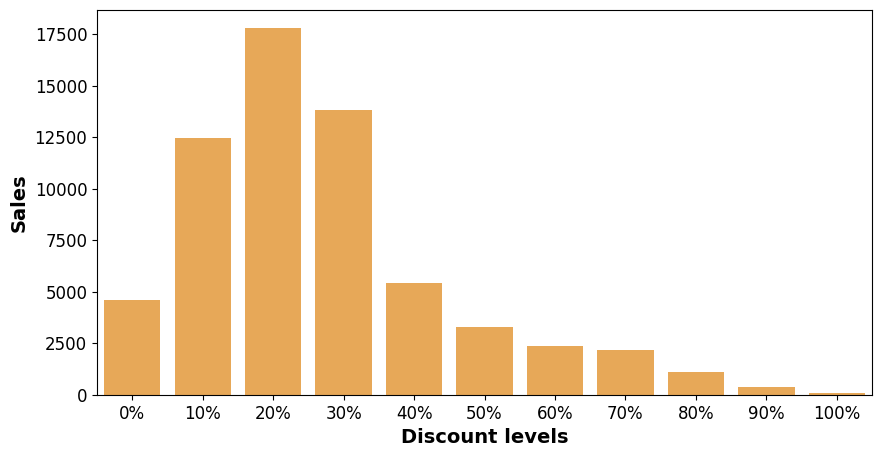

In [32]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = quantiles_df, x = 'quantiles', y = 'product_quantity', color = '#ffab40', ax = ax);
#modify individual font size of elements
plt.xlabel('Discount levels', fontsize=14, weight = 'bold');
plt.ylabel('Sales', fontsize=14, weight = 'bold');
plt.tick_params(axis='both', which='major', labelsize=12);
ax.xaxis.set_major_formatter(mtick.PercentFormatter(10))

## Discounts and revenue over time

In [33]:
agg_rev_prod_disc = orderlines_new_df.groupby([orderlines_new_df["date"].dt.to_period('W').dt.to_timestamp()]).agg({'discounts':'mean','product_quantity':'sum','revenue':'sum','id_order':'nunique'})

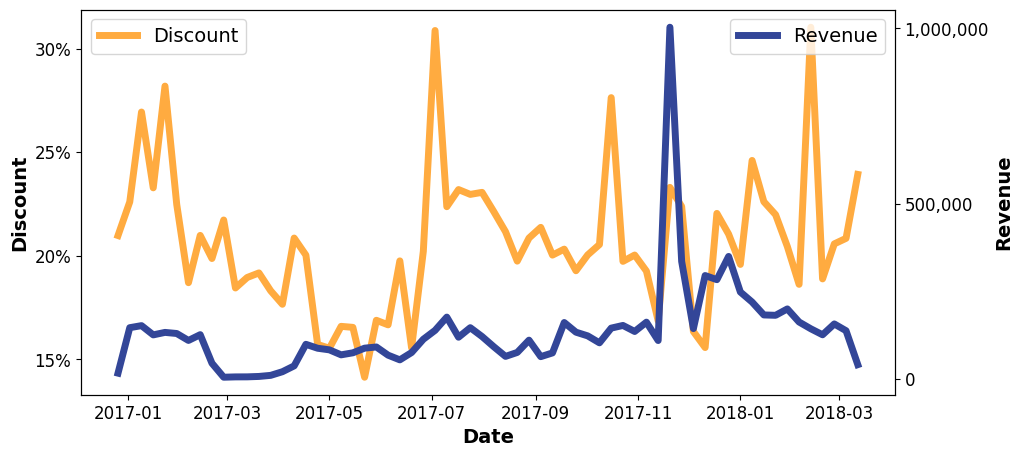

In [34]:
fig, ax1 = plt.subplots(figsize=(10.5, 5))
ax2 = ax1.twinx()
sns.lineplot(data = agg_rev_prod_disc, x = 'date', y = 'revenue', ax = ax2, color = '#334698', linewidth = 5)
sns.lineplot(data = agg_rev_prod_disc, x = 'date', y = 'discounts', ax = ax1, color = '#ffab40', linewidth = 5)
ax1.legend(['Discount'], fontsize = 14);
ax2.legend(['Revenue'], fontsize = 14);

# Set common labels
ax1.set_yticks(np.arange(0.15, 0.35, step=0.05))
ax2.set_yticks(np.arange(0,1200000, step=500000))
ax1.set_ylabel('Discount', fontsize = 14, weight='bold');
ax1.set_yticklabels(labels = ax1.get_yticklabels(), fontsize = 12)
ax1.set_xticklabels(labels = ax1.get_xticklabels(), fontsize = 12)

ax2.set_yticklabels(labels = ax2.get_yticklabels(), fontsize = 12)
ax2.set_ylabel('Revenue', fontsize = 14, weight='bold')
ax1.set_xlabel('Date', fontsize = 14, weight='bold');

ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()]);


import matplotlib.ticker as mtick
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 0))

## Discounts and revenue by category

In [35]:
agg_main_category = (
    orderlines_new_df.groupby('main_category').
    agg({'revenue': ['sum', 'mean', 'std'], 
         'unit_price': ['min', 'max', 'mean', 'std'],
         'discounts': ['min','max','mean','std']}))

agg_main_category.reset_index(inplace = True)

agg_main_category.columns = ["_".join(pair) for pair in agg_main_category.columns]

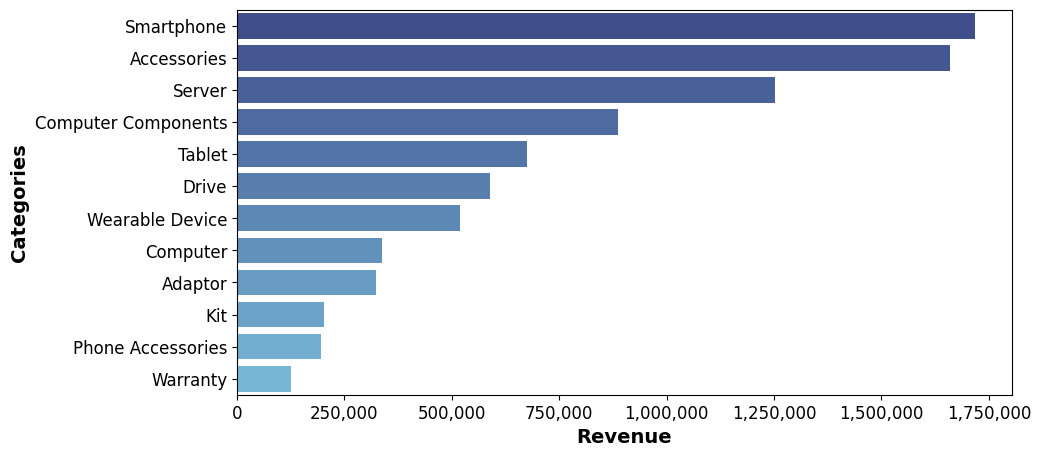

In [36]:
fig, ax1 = plt.subplots(figsize=(10,5))
# ax2 = ax1.twiny()
sns.barplot(data = agg_main_category.sort_values(by = 'revenue_sum', ascending = False),
            x= 'revenue_sum',
            y="main_category_",
            palette = sns.blend_palette(colors = ['#334698','#66BDE6'], n_colors = 12),
            ax = ax1);
# sns.lineplot(data = agg_main_category.sort_values(by = 'revenue_sum', ascending = False),
#              orient = 'y',
#              sort = True,
#              x = 'discounts_mean',
#              y = 'main_category_',
#              color = '#ffab40',
#              linewidth = 3,
#              ax = ax2);

ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks().tolist()])
# ax2.set_xlabel('Average discount', fontsize = 14, weight = 'bold');
# ax2.set_xticklabels(labels = ax2.get_xticklabels(), fontsize = 12)
ax1.set_xticklabels(labels = ax1.get_xticklabels(), fontsize = 12)
ax1.set_yticklabels(labels = agg_main_category.sort_values(by = 'revenue_sum', ascending = False).main_category_.str.replace('_', ' ').str.title(), fontsize = 12)
ax1.set_ylabel('Categories', fontsize = 14, weight = 'bold')
ax1.set_xlabel('Revenue', fontsize = 14, weight = 'bold');

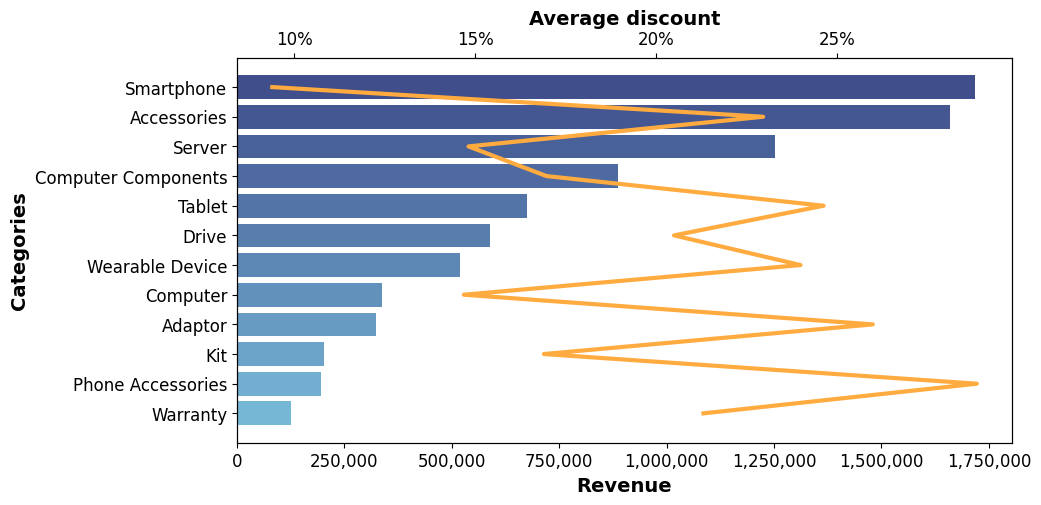

In [37]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twiny()
sns.barplot(data = agg_main_category.sort_values(by = 'revenue_sum', ascending = False),
            x= 'revenue_sum',
            y="main_category_",
            palette = sns.blend_palette(colors = ['#334698','#66BDE6'], n_colors = 12),
            ax = ax1);
sns.lineplot(data = agg_main_category.sort_values(by = 'revenue_sum', ascending = False),
             orient = 'y',
             sort = True,
             x = 'discounts_mean',
             y = 'main_category_',
             color = '#ffab40',
             linewidth = 3,
             ax = ax2);

ax2.set_xticks(np.arange(0.1, 0.3, step = 0.05))
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks().tolist()])
ax2.set_xlabel('Average discount', fontsize = 14, weight = 'bold');
ax2.set_xticklabels(labels = ax2.get_xticklabels(), fontsize = 12)
ax1.set_xticklabels(labels = ax1.get_xticklabels(), fontsize = 12)
ax1.set_yticklabels(labels = agg_main_category.sort_values(by = 'revenue_sum', ascending = False).main_category_.str.replace('_', ' ').str.title(), fontsize = 12)
ax1.set_ylabel('Categories', fontsize = 14, weight = 'bold')
ax1.set_xlabel('Revenue', fontsize = 14, weight = 'bold')
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 0));

## Prices by category

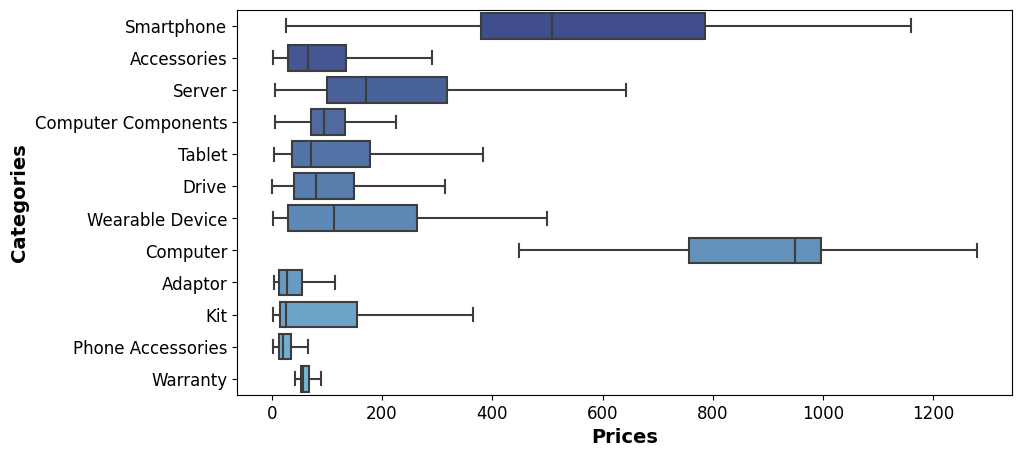

In [38]:
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.boxplot(data = orderlines_new_df, 
            x = 'unit_price', 
            y = 'main_category', 
            palette = sns.blend_palette(colors = ['#334698','#66BDE6'], n_colors = 12),
            order = agg_main_category.sort_values(by = 'revenue_sum', ascending = False).main_category_,
            showfliers=False,
            ax = ax1)
ax1.set_ylabel('Categories', fontsize = 14, weight = 'bold')
ax1.set_xlabel('Prices', fontsize = 14, weight = 'bold')
ax1.set_xticklabels(labels = ax1.get_xticklabels(), fontsize = 12)
ax1.set_yticklabels(labels = agg_main_category.
                      sort_values(by = 'revenue_sum', ascending = False).
                      main_category_.str.replace('_', ' ').str.title(), 
                    fontsize = 12);